# Bitcoin Returns - Time Series Analysis

A cryptocurrency (or crypto currency) is a digital asset designed to work as a medium of exchange wherein individual coin ownership records are stored in a ledger existing in a form of computerized database using strong cryptography to secure transaction records, to control the creation of additional coins, and to verify the transfer of coin ownership.It typically does not exist in physical form (like paper money) and is typically not issued by a central authority. Cryptocurrencies typically use decentralized control as opposed to centralized digital currency and central banking systems.

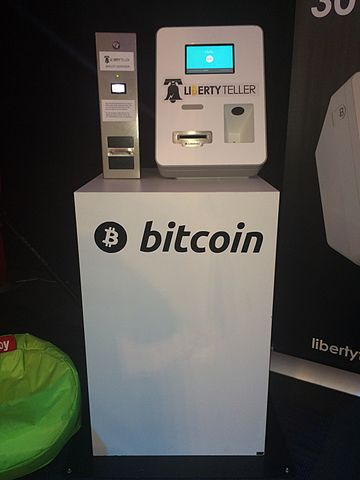

[Source: Wikipedia](https://en.wikipedia.org/wiki/Cryptocurrency)

Image by Martin E. Walder - Own work, CC BY-SA 3.0, https://commons.wikimedia.org/w/index.php?curid=35767746


# Contents

* [Some useful libraries](##Libraries)
* [Fetching the data](##Fetching-and-visualizing-the-data)
* [Bitcoin Returns Time Series Analysis](##Bitcoin-Returns-Time-Series-Analysis)
    * [Summary Statitistics](##Bitcoin-returns-summary-statitics)
    * [Stationarity](###Stationarity)
    * [Autocorrelation](###Autocorrelation)
    * [Distribution](##Distribution)





## Libraries

In [1]:
import os
import requests
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from matplotlib import markers
from scipy.stats import jarque_bera
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import btc_lib

%matplotlib inline
os.chdir(os.getcwd())

## Fetching and visualizing the data

Bitcoin (₿) is a cryptocurrency invented in 2008 by an unknown person or group of people using the name Satoshi Nakamoto and started in 2009 when its implementation was released as open-source software.

It is a decentralized digital currency without a central bank or single administrator that can be sent from user to user on the peer-to-peer bitcoin network without the need for intermediaries.Transactions are verified by network nodes through cryptography and recorded in a public distributed ledger called a blockchain. Bitcoins are created as a reward for a process known as mining.

[Source: Wikipedia](https://en.wikipedia.org/wiki/Bitcoin)

In [15]:
#scrape historical data from coinbase
btc_df=btc_lib.cb_hist_data_scrap('bitcoin',startdate='20130429',enddate='20191231')
btc_df.head()

,Open,High,Low,Close,Volume,Market Cap,name,Market_Cap_in_bn,Volume_in_bn
Date,,,,,,,,,
2013-04-29,134.44,147.49,134.00,144.54,0,1603768865,bitcoin,1.603769,0.0
2013-04-30,144.00,146.93,134.05,139.00,0,1542813125,bitcoin,1.542813,0.0
2013-05-01,139.00,139.89,107.72,116.99,0,1298954594,bitcoin,1.298955,0.0
2013-05-02,116.38,125.60,92.28,105.21,0,1168517495,bitcoin,1.168517,0.0
2013-05-03,106.25,108.13,79.10,97.75,0,1085995169,bitcoin,1.085995,0.0


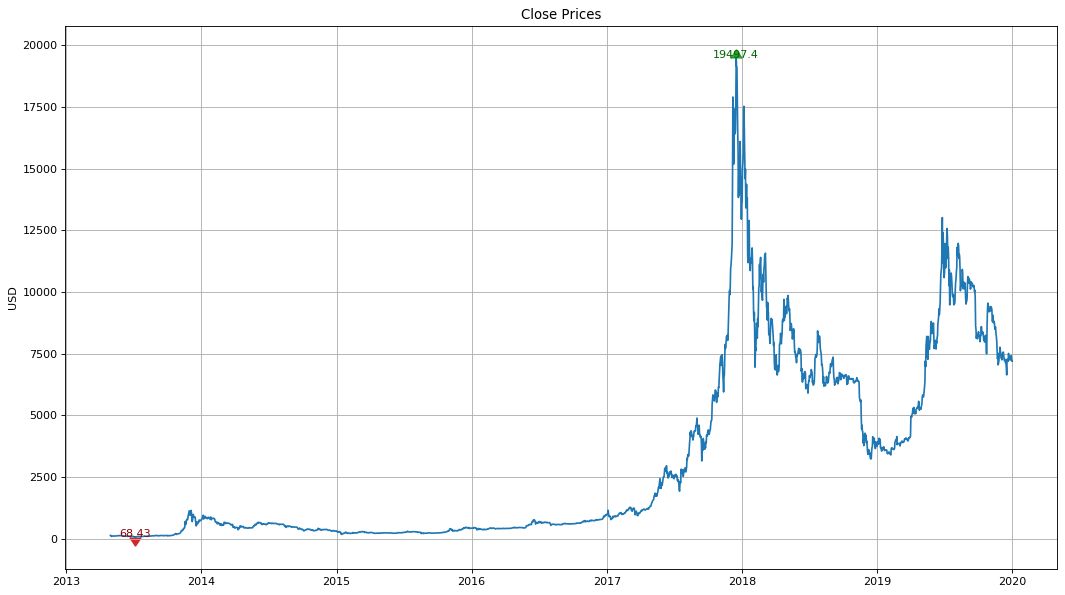

In [65]:
#Closing Price plot
fig, ax2 = plt.subplots(1,1,figsize=(16,9), dpi= 80)
ax2.plot(btc_df.index,btc_df['Close'])
ax2.set_title('Close Prices')
close_max = max(btc_df['Close'])
close_max_pos = btc_df[btc_df['Close']==(close_max)].index
close_max_date = btc_df.loc[close_max_pos].index

close_min = min(btc_df['Close'])
close_min_pos = btc_df[btc_df['Close']==(close_min)].index
close_min_date = btc_df.loc[close_min_pos].index

plt.scatter(close_max_date, close_max, marker=markers.CARETUPBASE, color='tab:green', s=100, label='Peak')
plt.scatter(close_min_date, close_min, marker=markers.CARETDOWNBASE, color='tab:red', s=100, label='Trough')

plt.text(close_max_date, close_max, close_max, horizontalalignment='center', color='darkgreen')
plt.text(close_min_date, close_min, close_min, horizontalalignment='center', color='darkred')

ax2.set_ylabel('USD')
ax2.grid()

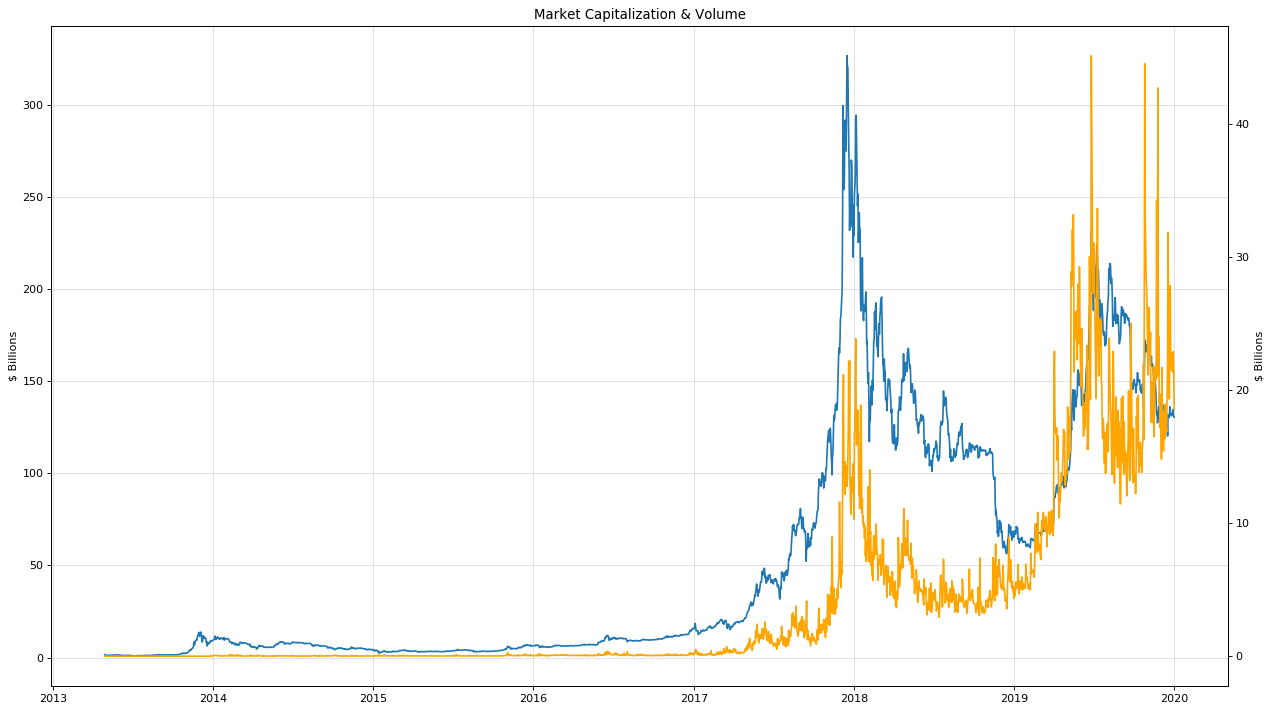

In [4]:
fig, ax1 = plt.subplots(figsize=(16,9), dpi= 80)

color = 'tab:red'
#ax1.set_xlabel('time (s)')
ax1.set_ylabel('$ Billions')
ax1.plot(btc_df.index,btc_df['Market_Cap_in_bn'])
ax1.tick_params(axis='y',rotation=0)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('$ Billions')
ax2.plot(btc_df.index,btc_df['Volume_in_bn'],color='orange')
ax2.tick_params(axis='y',rotation=0)

ax1.grid(alpha=.4)
ax1.set_title('Market Capitalization & Volume')

fig.tight_layout()  
plt.show()

## Bitcoin Returns Time Series Analysis

In [73]:
#add returns and logged returns to dataframe
btc_df['Returns']=btc_df['Close'].pct_change()
btc_df['Log_Returns']= np.log(btc_df['Close']) - np.log(btc_df['Close'].shift(1))

btc_df.dropna(inplace=True)

btc_df[['Returns','Log_Returns']].describe()

,Returns,Log_Returns
count,2437.000000,2437.000000
mean,0.002532,0.001620
std,0.042846,0.042678
min,-0.233713,-0.266198
25%,-0.012636,-0.012716
50%,0.001809,0.001807
75%,0.018341,0.018175
max,0.429680,0.357451


### Stationarity

Stationarity is an assumption underlying many statistical procedures used in time series analysis. A stationary time series is one whose properties do not depend on the time at which the series is observed. There are a few ways to look for stationarity in time series data:

#### Have a look at the graphic visualization of the data to spot any trend or seasonalities...

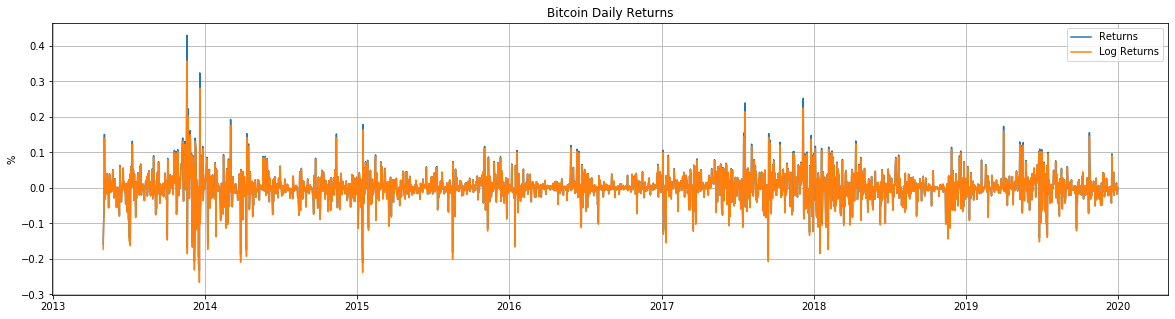

In [74]:
#Visual Inspection to see if there is any trend
fig,ax = plt.subplots(1,figsize=(20,5))
ax.plot(btc_df.index, btc_df[['Returns','Log_Returns']])
ax.legend(['Returns','Log Returns'])
ax.set_title('Bitcoin Daily Returns')
ax.set_ylabel('%')
ax.grid()


#### Have a look if summary statistics are consistent across different (equally sized) data intervals...

In [75]:
df_stats_rets=btc_lib.summary_stats_partition (btc_df['Returns'].values, 4)
df_stats_log_rets=btc_lib.summary_stats_partition (btc_df['Log_Returns'].values, 4)


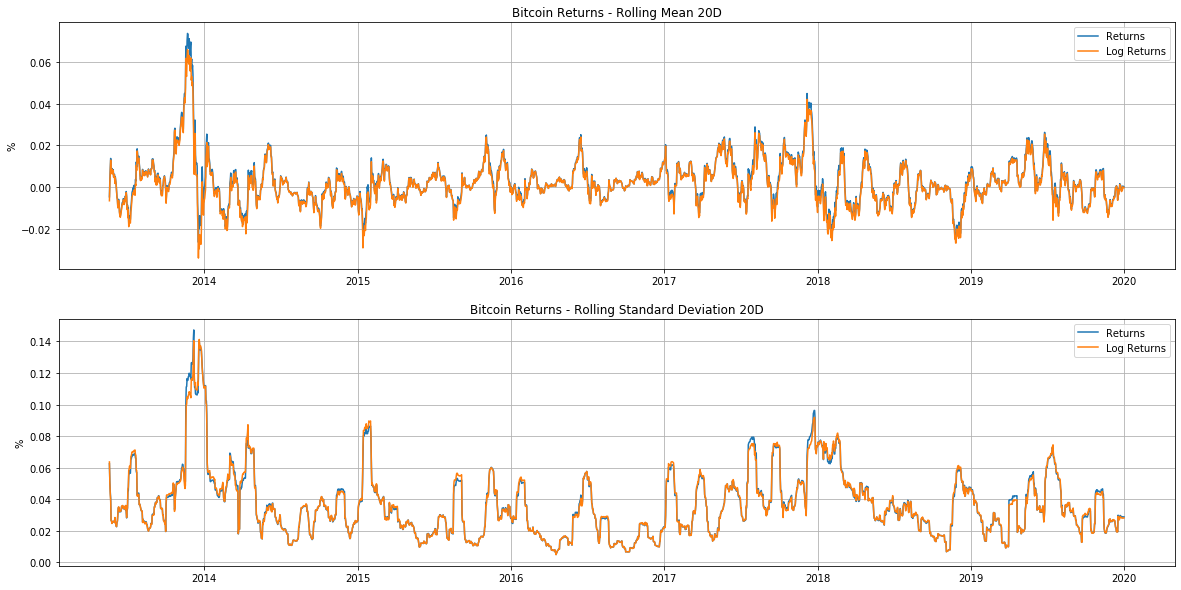

In [76]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1,figsize=(20, 10))
ax1.plot(btc_df.index,btc_df[['Returns','Log_Returns']].rolling(window=20).mean())
ax1.set_title('Bitcoin Returns - Rolling Mean 20D')
ax1.set_ylabel('%')
ax1.legend(['Returns','Log Returns'])
ax1.grid()


ax2.plot(btc_df.index,btc_df[['Returns','Log_Returns']].rolling(window=20).std())
ax2.set_title('Bitcoin Returns - Rolling Standard Deviation 20D')
ax2.set_ylabel('%')
ax2.legend(['Returns','Log Returns'])
ax2.grid()

#btc_df[['Returns','Log_Returns']].rolling(window=20).mean().plot()
#btc_df[['Returns','Log_Returns']].rolling(window=20).std().plot()

#### Or simply perform a statistical test...

In [77]:
#AD-Fuller Test
btc_lib.is_stationary(btc_df['Returns'])

ADF Statistic: -12.494405
p-value: 0.000000
The series is stationary.
Critical values:
	1%: -3.433 
	5%: -2.863 
	10%: -2.567 


### Autocorrelation

In [78]:
#not autocorrelated
print("The autocorrelation of daily returns is %4.2f" %(btc_df['Returns'].autocorr()))

The autocorrelation of daily returns is -0.00


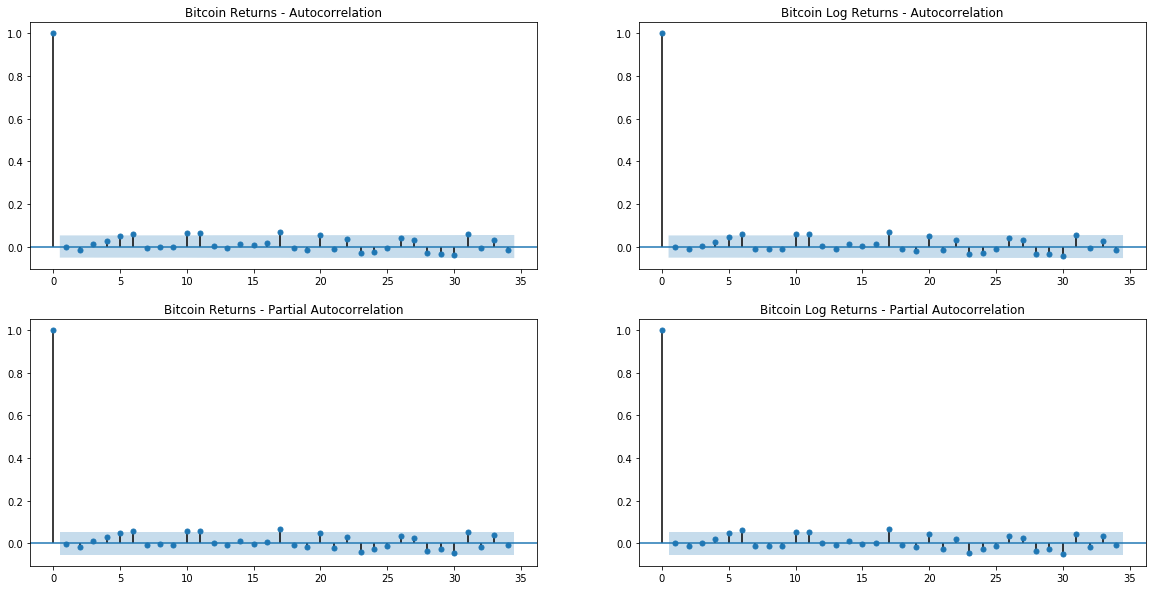

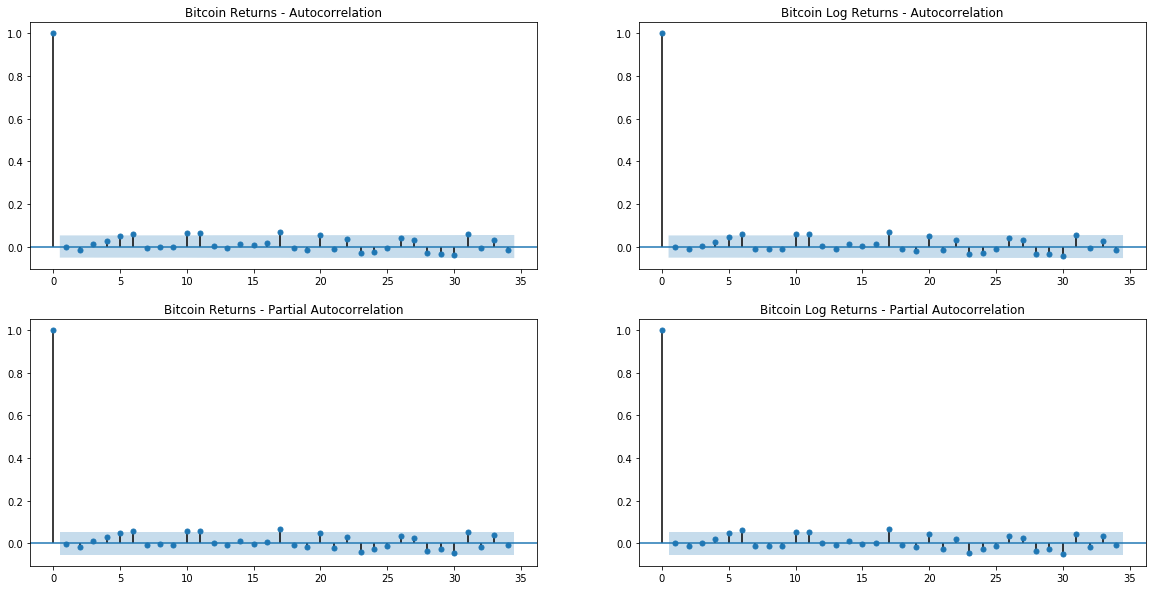

In [80]:
#can also be seen graphically. few lags that seem significant, low magnitude
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2,figsize=(20, 10))

plot_acf(btc_df['Returns'],alpha=0.01, title='Bitcoin Returns - Autocorrelation',ax=ax1)

plot_acf(btc_df['Log_Returns'],alpha=0.01,title='Bitcoin Log Returns - Autocorrelation',ax=ax2)

plot_pacf(btc_df['Returns'],alpha=0.01, title='Bitcoin Returns - Partial Autocorrelation',ax=ax3)

plot_pacf(btc_df['Log_Returns'],alpha=0.01, title='Bitcoin Log Returns - Partial Autocorrelation',ax=ax4)


### Distribution

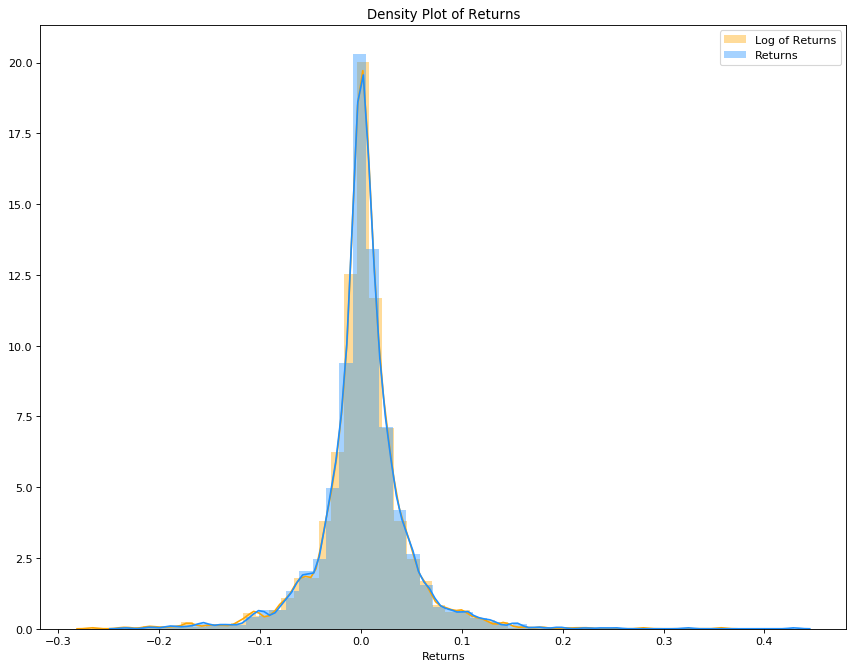

In [95]:
import seaborn as sns
plt.figure(figsize=(13,10), dpi= 80)
sns.distplot(btc_df['Log_Returns'], color="orange", label="Log of Returns", hist=True)
sns.distplot(btc_df['Returns'], color="dodgerblue", label="Returns",hist=True)

# Decoration
plt.title('Density Plot of Returns')

plt.legend()

plt.show()


In [106]:
#Visualize  kurtosis, skewness
print("Daily Returns Distribution:")
btc_lib.skewness(btc_df['Returns'],ddof=0)
btc_lib.kurtosis(btc_df['Returns'],ddof=0)

print("-------------------")
print("Daily Log Returns Distribution:")
btc_lib.skewness(btc_df['Log_Returns'],ddof=0)
btc_lib.kurtosis(btc_df['Log_Returns'],ddof=0)

Daily Returns Distribution:
Skewness: 0.505247
Distribution is right skewed
Kurtosis: 12.685837
Distribution is leptokurtic
-------------------
Daily Log Returns Distribution:
Skewness: -0.152735
Distribution is left skewed
Kurtosis: 10.745315
Distribution is leptokurtic


10.74531542604589

In [107]:
print("Daily Returns Distribution:")
btc_lib.jb_test_is_normal(btc_df['Returns'], critical_level=0.01)
print("---------------------")
print("Daily Returns Distribution:")
btc_lib.jb_test_is_normal(btc_df['Log_Returns'], critical_level=0.01)

Daily Returns Distribution:
J_B Statistic: 9633.812123
p-value: 0.000000
The series is not normal.
---------------------
Daily Returns Distribution:
J_B Statistic: 6103.454038
p-value: 0.000000
The series is not normal.
